# Ball on incline

## Author(s), contact(s), and dates:
- Author: Nan Normann Jakobsen
- Email:  nnj@chem.ku.dk
- Date:   7th of December 2023 (latest update)

In [2]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from IPython.core.display import Latex
from sympy import * 
import os
import pandas as pd

sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [4]:
meas_path = 'Applied statistics lab exercises - Ball on an incline.csv'
meas_df = pd.read_csv(meas_path, sep = ';', decimal = ',')

In [5]:
def get_mean_s(df, keys, sigma_col):
    df_prop = df[keys]
    mean = []
    sigma_mean = []
    weigthed_mean = []
    for key in df_prop:
        mu = np.sum(df_prop[key]) / len(df_prop[key])
        std = np.sqrt((1 / (len(df_prop[key]) - 1)) * np.sum((df_prop[key] - mu)**2))
        mean.append(mu)
        sigma_mean.append(std)
        mu_w = np.sum(df_prop[key] / df[sigma_col]**2) / np.sum(1 / df[sigma_col]**2)
        weigthed_mean.append(mu_w)
    sigma_wmean = np.sqrt(1 / np.sum(1 / df[sigma_col]**2))
    return mean, sigma_mean, weigthed_mean, sigma_wmean

def chi2_mean(chi2):
    mu = np.sum(chi2) / len(chi2)
    std = np.sqrt((1 / (len(chi2) - 1)) * np.sum((chi2 - mu)**2))
    return mu, std

def get_mean(x, ex):
    mu, std = chi2_mean(x)
    mu_w = np.sum(x / ex**2) / np.sum(1 / ex**2)
    sigma_wmean = np.sqrt(1 / np.sum(1 / ex**2))
    return mu, std, mu_w, sigma_wmean

In [6]:
s_mean, sigma_s, s_wmean, sigma_ws = get_mean_s(meas_df / 100, meas_df.keys()[8:13], 'sigma s') # division by 100 to convert from cm to m
print('Weighted mean', s_wmean)
print('weigthed error on mean', sigma_ws)

Weighted mean [0.2441451612903226, 0.3953935483870968, 0.5530032258064517, 0.7187612903225806, 0.8962903225806451]
weigthed error on mean 0.0010776318121606494


In [7]:
save_plots = True

Nexp = 20
Npoints = 5
V_thres = 2.5

def fit_function(t, a, v_0, s_0):
    return 0.5*a * t**2 + v_0 * t + s_0

### Data treatment of normal experiments

0 exp10_ball.txt   Fit: a= 1.525+-0.027  v_0=0.012+-0.020  s_0=0.094+-0.007  Chi2=1.9180  p=0.3833


1 exp11_ball.txt   Fit: a= 1.525+-0.027  v_0=-0.035+-0.021  s_0=0.092+-0.007  Chi2=1.5821  p=0.4534
2 exp12_ball.txt   Fit: a= 1.523+-0.027  v_0=-0.293+-0.025  s_0=0.120+-0.011  Chi2=1.7310  p=0.4208
3 exp13_ball.txt   Fit: a= 1.525+-0.027  v_0=0.017+-0.020  s_0=0.093+-0.007  Chi2=2.0498  p=0.3588
4 exp14_ball.txt   Fit: a= 1.522+-0.027  v_0=-0.327+-0.026  s_0=0.126+-0.012  Chi2=1.8466  p=0.3972
5 exp15_ball.txt   Fit: a= 1.523+-0.027  v_0=0.007+-0.020  s_0=0.092+-0.007  Chi2=1.8621  p=0.3941
6 exp16_ball.txt   Fit: a= 1.522+-0.027  v_0=-0.136+-0.022  s_0=0.098+-0.009  Chi2=2.0235  p=0.3636
7 exp17_ball.txt   Fit: a= 1.517+-0.027  v_0=-0.202+-0.024  s_0=0.103+-0.010  Chi2=2.1215  p=0.3462
8 exp18_ball.txt   Fit: a= 1.522+-0.027  v_0=-1.846+-0.053  s_0=1.210+-0.051  Chi2=1.8466  p=0.3972
9 exp19_ball.txt   Fit: a= 1.523+-0.027  v_0=0.272+-0.015  s_0=0.116+-0.004  Chi2=1.8621  p=0.3941
10 exp1_ball.txt   Fit: a= 1.519+-0.027  v_0=-0.057+-0.021  s_0=0.093+-0.008  Chi2=1.7383  p=0.4193
11 

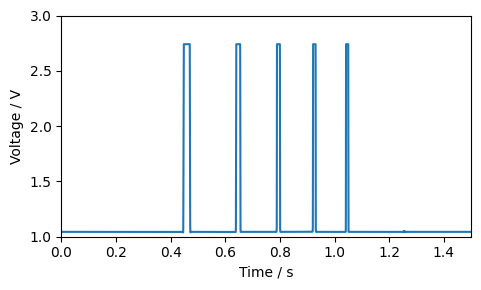

In [8]:
Minuit.print_level = 0

fig_norm, ax_norm = plt.subplots(figsize=(5,3))

# Arrays for storing fit results:
array_a = np.zeros(Nexp)
array_sigmaa = np.zeros(Nexp)
array_v0 = np.zeros(Nexp)
array_sigmav0 = np.zeros(Nexp)
array_s0 = np.zeros(Nexp)
array_sigmas0 = np.zeros(Nexp)
array_Chi2 = np.zeros(Nexp)
array_Prob = np.zeros(Nexp)

directory = '../Project'

# Loop, repeating the data generation and fit:
for iexp, filename in enumerate(os.listdir(directory)):  # https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
    if 'ball.txt' in filename:
        if 'rev' in filename:
            pass
        else:
            f = pd.read_table(filename, sep = '\t', skiprows = 14)

            t = []
            for i in range(len(f['Channel 1 (V)'])):
                if f['Channel 1 (V)'][i]>V_thres>f['Channel 1 (V)'][i+1]:
                    t.append(f['Time (s)'][i])

            s = s_wmean
            es = sigma_ws
            t = np.array(t)

            # Define a ChiSquare to be minimised (using ExternalFunctions):

            # Alternatively, you can define Chi2 calculation:
            def chi2_owncalc(a, v_0, s_0) : # , alpha1
                s_fit = fit_function(t, a, v_0, s_0) # , alpha1
                chi2 = np.sum(((s - s_fit) / es)**2)
                return chi2
            chi2_owncalc.errordef = 1.0

            # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
            minuit = Minuit(chi2_owncalc, a = 1.0, v_0 = 0.0, s_0 = 0.0) # initial guess

            # Perform the actual fit:
            minuit.migrad()

            # Extract the fitting parameters and their errors:
            a_fit = minuit.values['a']
            v0_fit = minuit.values['v_0']
            s0_fit = minuit.values['s_0']
            sigma_a_fit = minuit.errors['a']
            sigma_v0_fit = minuit.errors['v_0']
            sigma_s0_fit = minuit.errors['s_0']

            Nvar = 3                     # Number of variables
            Ndof_fit = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

            # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
            Chi2_fit = minuit.fval                          # The chi2 value
            Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

            # Fill the arrays with fit results (to produce plots of these at the end):
            i = int(iexp/2 - 1)
            array_a[i] = a_fit
            array_v0[i] = v0_fit
            array_s0[i] = s0_fit
            array_Chi2[i] = Chi2_fit
            array_Prob[i] = Prob_fit

            array_sigmaa[i] = sigma_a_fit
            array_sigmav0[i] = sigma_v0_fit
            array_sigmas0[i] = sigma_s0_fit
            
            # Let us see what the fit gives for the first couple of data sets:
            # print(filename, i)
            print(i, filename, 
                  f"  Fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  v_0={v0_fit:5.3f}+-{sigma_v0_fit:5.3f}  s_0={s0_fit:5.3f}+-{sigma_s0_fit:5.3f}  Chi2={Chi2_fit:6.4f}  p={Prob_fit:6.4f}")
            if i == 1:
                ax_norm.plot(f['Time (s)'], f['Channel 1 (V)'])

                ax_norm.set_xlabel('Time / s')
                ax_norm.set_ylabel('Voltage / V')
                ax_norm.set_xlim(0, 1.5)
                ax_norm.set_ylim(1, 3)

                fig_norm.tight_layout()
                if (save_plots) :
                    fig_norm.savefig("exp_example.png", dpi = 150)
                fig_norm



In [9]:
res = fit_function(t, *minuit.values[:]) - s
print(res)

[-6.72401438e-05  4.39377600e-04 -9.19524917e-04  7.95168762e-04
 -2.47780791e-04]


In [10]:
t_values = np.linspace(0, 1.2, 1000)

fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(t, s, color = 'r')
ax.plot(t_values, fit_function(t_values, *minuit.values[:]), '-k', zorder = -10)     # Note how we can "smartly" input the fit values!

ax_res = ax.twinx()
ax_res.hlines(0, min(t_values), max(t_values), color = 'k', lw = 1, ls = '--')
ax_res.errorbar(t, res, es, fmt = "o", color='b', ecolor='k', elinewidth=2, capsize=2, capthick=1)
plt.close()

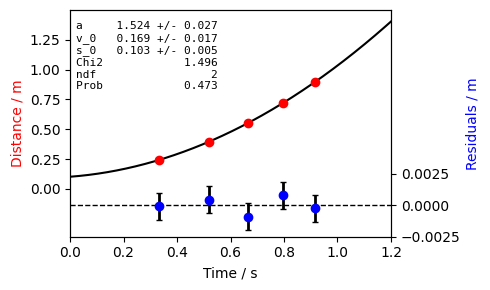

In [11]:
d = {'a':   [a_fit, sigma_a_fit],
     'v_0':   [v0_fit, sigma_v0_fit],
     's_0':     [s0_fit, sigma_s0_fit],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=8)

ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25])
ax_res.set_yticks([-0.0025, 0, 0.0025])

ax.set_ylabel('Distance / m', color = 'r')
ax_res.set_ylabel('Residuals / m', color = 'b')
ax.set_xlabel('Time / s')

ax.set_xlim(min(t_values), max(t_values))
sep_pro = 0.3

ax.set_ylim(-0.4, 1.5)
ax_res.set_ylim(-0.0025, 0.0155)
# print(ax.get_ylim[0])
# ax.set_ylim(ax.get_ylim()[0]-sep_pro*(np.diff(ax.get_ylim())), ax.get_ylim()[1])
# ax_res.set_ylim(ax_res.get_ylim()[0], ax_res.get_ylim()[1]+(1/sep_pro)*(np.diff(ax_res.get_ylim())))

fig.tight_layout()
if (save_plots) :
    fig.savefig("FitToParabola.png", dpi = 150)
fig

In [12]:
# a_mean, sigma_a, a_wmean, sigma_wa = get_mean(array_a, array_sigmaa)
a_wmean = array_a.mean()
sigma_wa = array_sigmaa.mean()
a_std = array_a.std(ddof=1)
# print('mean of a:', a_mean, '+-', sigma_a)
print('mean of a:', a_wmean, '+-', sigma_wa)
print(a_std)

v0_mean, sigma_v0, v0_wmean, sigma_wv0 = get_mean(array_v0, array_sigmav0)
# print('mean of v0:', v0_mean, '+-', sigma_v0)
# print('weighted mean of v0:', v0_wmean, '+-', sigma_wv0)

s0_mean, sigma_s0, s0_wmean, sigma_ws0 = get_mean(array_s0, array_sigmas0)
# print('mean of s0:', s0_mean, '+-', sigma_s0)
# print('weighted mean of s0:', s0_wmean, '+-', sigma_ws0)

Chi2_mean = array_Chi2.mean()
Chi2_std = array_Chi2.std(ddof=1)

print('mean and standard deviation of Chi2:', Chi2_mean, '+-', Chi2_std)

mean of a: 1.522480453605753 +- 0.027116811990872736
0.0024258445589512593
mean and standard deviation of Chi2: 1.8529146905453362 +- 0.19466732094173386


### Data treatment of reversed experiments

0 exp10_rev_ball.txt   Fit: a= 1.442+-0.026  v_0=0.228+-0.016  s_0=0.109+-0.004 Chi2=1.9247  p=0.3820
1 exp11_rev_ball.txt   Fit: a= 1.439+-0.026  v_0=0.224+-0.016  s_0=0.108+-0.004 Chi2=2.2132  p=0.3307
2 exp12_rev_ball.txt   Fit: a= 1.438+-0.026  v_0=-0.169+-0.023  s_0=0.100+-0.010 Chi2=1.7689  p=0.4129
3 exp13_rev_ball.txt   Fit: a= 1.439+-0.026  v_0=0.052+-0.019  s_0=0.092+-0.006 Chi2=2.2132  p=0.3307
4 exp14_rev_ball.txt   Fit: a= 1.443+-0.026  v_0=0.233+-0.015  s_0=0.111+-0.004 Chi2=2.2367  p=0.3268
5 exp15_rev_ball.txt   Fit: a= 1.444+-0.026  v_0=0.333+-0.014  s_0=0.130+-0.003 Chi2=1.9366  p=0.3797
6 exp16_rev_ball.txt   Fit: a= 1.438+-0.026  v_0=0.208+-0.016  s_0=0.105+-0.005 Chi2=1.7689  p=0.4129
7 exp17_rev_ball.txt   Fit: a= 1.438+-0.026  v_0=0.262+-0.015  s_0=0.116+-0.004 Chi2=1.7108  p=0.4251
8 exp18_rev_ball.txt   Fit: a= 1.444+-0.026  v_0=0.264+-0.015  s_0=0.117+-0.004 Chi2=2.2513  p=0.3244
9 exp19_rev_ball.txt   Fit: a= 1.439+-0.026  v_0=-0.802+-0.034  s_0=0.315+-0.022 

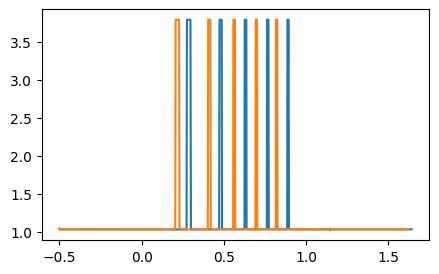

In [32]:
Minuit.print_level = 0

fig_rev, ax_rev = plt.subplots(figsize=(5,3))

# Arrays for storing fit results:
array_a_rev = np.zeros(Nexp)
array_sigmaa_rev = np.zeros(Nexp)
array_v0_rev = np.zeros(Nexp)
array_sigmav0_rev = np.zeros(Nexp)
array_s0_rev = np.zeros(Nexp)
array_sigmas0_rev = np.zeros(Nexp)
array_Chi2_rev = np.zeros(Nexp)
array_Prob_rev = np.zeros(Nexp)

directory = '../Project'

# Loop, repeating the data generation and fit:
for iexp, filename in enumerate(os.listdir(directory)):  # https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
    if 'ball.txt' in filename:
        if 'rev' not in filename:
            pass
        else:
            f = pd.read_table(filename, sep = '\t', skiprows = 14)

            t = []
            for i in range(len(f['Channel 1 (V)'])):
                if f['Channel 1 (V)'][i]>V_thres>f['Channel 1 (V)'][i+1]:
                    t.append(f['Time (s)'][i])

            s = s_wmean
            es = sigma_ws
            t = np.array(t)

            # Define a ChiSquare to be minimised (using ExternalFunctions):

            # Alternatively, you can define Chi2 calculation:
            def chi2_owncalc(a, v_0, s_0) : # , alpha1
                s_fit = fit_function(t, a, v_0, s_0) # , alpha1
                chi2 = np.sum(((s - s_fit) / es)**2)
                return chi2
            chi2_owncalc.errordef = 1.0

            # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
            minuit = Minuit(chi2_owncalc, a = 1.0, v_0 = 0.0, s_0 = 0.0) # initial guess

            # Perform the actual fit:
            minuit.migrad()

            # Extract the fitting parameters and their errors:
            a_fit = minuit.values['a']
            v0_fit = minuit.values['v_0']
            s0_fit = minuit.values['s_0']
            sigma_a_fit = minuit.errors['a']
            sigma_v0_fit = minuit.errors['v_0']
            sigma_s0_fit = minuit.errors['s_0']

            Nvar = 3                     # Number of variables
            Ndof_fit = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

            # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
            Chi2_fit = minuit.fval                          # The chi2 value
            Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

            # Fill the arrays with fit results (to produce plots of these at the end):
            i = int(iexp/2 - 2)
            array_a_rev[i] = a_fit
            array_v0_rev[i] = v0_fit
            array_s0_rev[i] = s0_fit
            array_Chi2_rev[i] = Chi2_fit
            array_Prob_rev[i] = Prob_fit

            array_sigmaa_rev[i] = sigma_a_fit
            array_sigmav0_rev[i] = sigma_v0_fit
            array_sigmas0_rev[i] = sigma_s0_fit
            
            # Let us see what the fit gives for the first couple of data sets:
            print(i, filename,
                  f"  Fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  v_0={v0_fit:5.3f}+-{sigma_v0_fit:5.3f}  s_0={s0_fit:5.3f}+-{sigma_s0_fit:5.3f} Chi2={Chi2_fit:6.4f}  p={Prob_fit:6.4f}")

            if (3 < i < 6):
                ax_rev.plot(f['Time (s)'], f['Channel 1 (V)'])

In [14]:
t_values = np.linspace(0, 1.2, 1000)

fig2, ax2 = plt.subplots(figsize=(5,3))
ax2.errorbar(t, s, es, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax2.plot(t_values, fit_function(t_values, *minuit.values[:]), '-k')     # Note how we can "smartly" input the fit values!

ax2_res = ax2.twinx()
ax2_res.hlines(0, min(t_values), max(t_values), color = 'k', lw = 1, ls = '--')
ax2_res.errorbar(t, res, es, fmt = "o", color='b', ecolor='k', elinewidth=2, capsize=2, capthick=1)
plt.close()

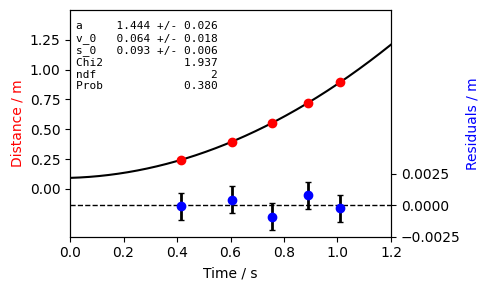

In [15]:
d = {'a':   [a_fit, sigma_a_fit],
     'v_0':   [v0_fit, sigma_v0_fit],
     's_0':     [s0_fit, sigma_s0_fit],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=8)

ax2.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25])
ax2_res.set_yticks([-0.0025, 0, 0.0025])

ax2.set_ylabel('Distance / m', color = 'r')
ax2_res.set_ylabel('Residuals / m', color = 'b')
ax2.set_xlabel('Time / s')

ax2.set_xlim(min(t_values), max(t_values))
sep_pro = 0.3

ax2.set_ylim(-0.4, 1.5)
ax2_res.set_ylim(-0.0025, 0.0155)

fig2.tight_layout()
if (save_plots) :
    fig2.savefig("FitToParabola_rev.png", dpi = 150)
fig2

In [16]:
# a_mean_rev, sigma_a_rev, a_wmean_rev, sigma_wa_rev = get_mean(array_a_rev, array_sigmaa_rev)
a_wmean_rev = array_a_rev.mean()
sigma_wa_rev = array_sigmaa_rev.mean()
a_std_r = array_a_rev.std(ddof=1)
# print('mean of a_rev:', a_mean_rev, '+-', sigma_a_rev)
print('mean of a_rev:', a_wmean_rev, '+-', sigma_wa_rev)
print(a_std_r)
# print(array_a_rev.mean(), array_sigmaa_rev.mean())

v0_mean_rev, sigma_v0_rev, v0_wmean_rev, sigma_wv0_rev = get_mean(array_v0_rev, array_sigmav0_rev)
# print('mean of v0:', v0_mean_rev, '+-', sigma_v0_rev)
# print('weighted mean of v0:', v0_wmean_rev, '+-', sigma_wv0_rev)

s0_mean_rev, sigma_s0_rev, s0_wmean_rev, sigma_ws0_rev = get_mean(array_s0_rev, array_sigmas0_rev)
# print('mean of s0:', s0_mean_rev, '+-', sigma_s0_rev)
# print('weighted mean of s0:', s0_wmean_rev, '+-', sigma_ws0_rev)

Chi2_mean_rev = array_Chi2_rev.mean()
Chi2_std_rev = array_Chi2_rev.std(ddof=1)

print('mean and standard deviation of Chi2:', Chi2_mean_rev, '+-', Chi2_std_rev)

mean of a_rev: 1.4403266508843988 +- 0.025689696271652553
0.0023037694806703098
mean and standard deviation of Chi2: 1.925580377990227 +- 0.20805118927150282


### Calculation of theta and Delta theta

In [17]:
L_mean, sigma_L, L_wmean, sigma_wL = get_mean(meas_df['lenght'] / 100, meas_df['sigma length'] / 100)
print('weighted mean of length:', L_wmean, '+-', sigma_wL)
H_mean, sigma_H, H_wmean, sigma_wH = get_mean(meas_df['height'] / 100, meas_df['sigma height'] / 100)
print('weighted mean of height:', H_wmean, '+-', sigma_wH)

weighted mean of length: 0.9029430379746836 +- 0.001125087900926024
weighted mean of height: 0.22284 +- 0.00031622776601683794


In [18]:
# Define variables:
L,H,theta_trig = symbols("L, H, theta_t")
dL,dH,dtheta_trig = symbols("sigma_L, sigma_H, sigma_theta_t")

# Define relation, and print:
theta_trig = atan(H/L)
lprint(latex(Eq(symbols('theta_t'),theta_trig)))

# Calculate uncertainty and print:
dtheta_trig = sqrt((theta_trig.diff(L) * dL)**2 + (theta_trig.diff(H) * dH)**2)
lprint(latex(Eq(symbols('sigma_theta_t'), dtheta_trig)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
ftheta_trig = lambdify((L,H),theta_trig)
fdtheta_trig = lambdify((L,dL,H,dH),dtheta_trig)

# Define values and their errors
vL, vdL = L_wmean, sigma_wL
vH, vdH = H_wmean, sigma_wH

# Numerically evaluate expressions and print 
vtheta_trig = ftheta_trig(vL,vH)
vdtheta_trig = fdtheta_trig(vL,vdL,vH,vdH)
lprint(fr'theta_t = {vtheta_trig:.5f} \pm {vdtheta_trig:.5f}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [19]:
# Define variables:
Dth,a_n,a_r,th = symbols("Deltatheta, a_n, a_r, theta")
dDth,da_n,da_r,dth = symbols("sigma_Delta_theta, sigma_a_n, sigma_a_r, sigma_theta")

# Define relation, and print:
Dth = ((a_n - a_r) * sin(th)) / ((a_n + a_r) * cos(th))
lprint(latex(Eq(symbols('Delta_theta'),Dth)))

# Calculate uncertainty and print:
dDth = sqrt((Dth.diff(a_n) * da_n)**2 + (Dth.diff(a_r) * da_r)**2 + (Dth.diff(th) * dth)**2)
lprint(latex(Eq(symbols('sigma_Delta_theta'), dDth)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fDth = lambdify((a_n,a_r,th),Dth)
fdDth = lambdify((a_n,da_n,a_r,da_r,th,dth),dDth)

# Define values and their errors
va_n, vda_n = a_wmean, sigma_wa
va_r, vda_r = a_wmean_rev, sigma_wa_rev
vth, vdth = vtheta_trig, vdtheta_trig

# Numerically evaluate expressions and print 
vDth = fDth(va_n,va_r,vth)
vdDth = fdDth(va_n,vda_n,va_r,vda_r,vth,vdth)
lprint(fr'Delta theta = {vDth:.5f} \pm {vdDth:.5f}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [20]:
theta_norm_df = pd.concat([pd.concat([meas_df['theta_norm'] * np.pi/180, meas_df['theta_norm_rev'] * np.pi/180], ignore_index = True), 
                  pd.concat([meas_df['sigma theta_norm'] * np.pi/180, meas_df['sigma theta_norm_rev'] * np.pi/180], ignore_index = True)]
                  , axis = 1)
theta_rev_df = pd.concat([pd.concat([meas_df['theta_rev'] * np.pi/180, meas_df['theta_rev_rev'] * np.pi/180], ignore_index = True), 
                          pd.concat([meas_df['sigma theta_rev'] * np.pi/180, meas_df['sigma theta_rev_rev'] * np.pi/180], ignore_index = True)]
                          , axis = 1)
ball_full_df = pd.concat([pd.concat([meas_df['D_ball1'], meas_df['D_ball2']], ignore_index = True), 
                  pd.concat([meas_df['sigma D_ball1'], meas_df['sigma D_ball2']], ignore_index = True)]
                  , axis = 1)

In [21]:
theta_norm, sigma_theta_norm, wtheta_norm, sigma_wtheta_norm = get_mean(theta_norm_df[0], theta_norm_df[1])
print('weighted mean of theta_norm:', wtheta_norm, '+-', sigma_wtheta_norm)
theta_rev, sigma_theta_rev, wtheta_rev, sigma_wtheta_rev = get_mean(theta_rev_df[0], theta_rev_df[1])
print('weighted mean of theta_rev:', wtheta_rev, '+-', sigma_wtheta_rev)
d_ball, sigma_dball, wd_ball, sigma_wdball = get_mean(ball_full_df[0] / 100, ball_full_df[1] / 100) # division with 100 to convert cm to m
print('weighted mean of ball diameter:', wd_ball, '+-', sigma_wdball)
d_rail, sigma_drail, wd_rail, sigma_wdrail = get_mean(meas_df['d_railing'] / 100, meas_df['sigma d_railing'] / 100)
print('weighted mean of rail diameter:', wd_rail, '+-', sigma_wdrail)
a, ea, aw, eaw = get_mean(np.array([a_wmean, a_wmean_rev]), np.array([sigma_wa, sigma_wa_rev]))
print('weighted mean of acceleration:', aw, '+-', eaw)

weighted mean of theta_norm: 0.24756890622472044 +- 0.0007368056258695003
weighted mean of theta_rev: 0.23125612588924865 +- 0.0006845744548894912
weighted mean of ball diameter: 0.015029647870937718 +- 1.868225370728435e-05
weighted mean of rail diameter: 0.007305357142857143 +- 1.889822365046136e-05
weighted mean of acceleration: 1.479184935283974 +- 0.018649474800836598


In [22]:
# Define variables:
th,th_t,Dth = symbols("theta, theta_t, Delta_theta")
dth,dth_t,dDth = symbols("sigma_theta, sigma_theta_t, sigma_Delta_theta")

# Define relation, and print:
th = th_t + Dth
lprint(latex(Eq(symbols('theta'),th)))

# Calculate uncertainty and print:
dth = sqrt((th.diff(th_t) * dth_t)**2 + (th.diff(Dth) * dDth)**2)
lprint(latex(Eq(symbols('sigma_theta'), dth)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fth = lambdify((th_t,Dth),th)
fdth = lambdify((th_t,dth_t,Dth,dDth),dth)

# Define values and their errors
vth_t, vdth_t = vtheta_trig, vdtheta_trig
vDth, vdDth = vDth, vdDth

# Numerically evaluate expressions and print 
vth_trig = fth(vth_t,vDth)
vdth_trig = fdth(vth_t,vdth_t,vDth,vdDth)
lprint(fr'theta_t = {vth_trig:.5f} \pm {vdth_trig:.5f}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [23]:
# Define variables:
th,th_t,Dth = symbols("theta, theta_t, Delta_theta")
dth,dth_t,dDth = symbols("sigma_theta, sigma_theta_t, sigma_Delta_theta")

# Define relation, and print:
th = th_t - Dth
lprint(latex(Eq(symbols('theta'),th)))

# Calculate uncertainty and print:
dth = sqrt((th.diff(th_t) * dth_t)**2 + (th.diff(Dth) * dDth)**2)
lprint(latex(Eq(symbols('sigma_theta'), dth)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fth = lambdify((th_t,Dth),th)
fdth = lambdify((th_t,dth_t,Dth,dDth),dth)

# Define values and their errors
vth_t, vdth_t = vtheta_trig, vdtheta_trig
vDth, vdDth = vDth, vdDth

# Numerically evaluate expressions and print 
vth_trig_r = fth(vth_t,vDth)
vdth_trig_r = fdth(vth_t,vdth_t,vDth,vdDth)
lprint(fr'theta_t = {vth_trig_r:.5f} \pm {vdth_trig_r:.5f}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [24]:
theta_array = np.array([theta_norm, vth_trig]) # theta_rev, vth_trig_r
theta_errors = np.array([sigma_theta_norm, vdth_trig]) # , sigma_theta_rev, , vdth_trig_r
theta_mean, sigma_theta_mean, theta_wmean, sigma_theta_wmean = get_mean(theta_array, theta_errors)
print('weighted mean of theta:', theta_wmean, '+-', sigma_theta_wmean)

weighted mean of theta: 0.24836169580634437 +- 0.002737804762810348


## Calculation of g

### for normal experiments

#### Using theta obtained with goniometer

In [25]:
# Define variables:
g_g,a_n,th,Db,Dr = symbols("g_g, a_n, theta, D_b, D_r")
dg_g,da_n,dth,dDb,dDr = symbols("sigma_g_g, sigma_a_n, sigma_theta, sigma_D_b, sigma_D_r")

# Define relation, and print:
g_g = (a_n / sin(th)) * (1 + (2/5) * Db**2 / (Db**2 - Dr**2))
lprint(latex(Eq(symbols('g_g'),g_g)))

# Calculate uncertainty and print:
dg_g = sqrt((g_g.diff(a_n) * da_n)**2 + (g_g.diff(th) * dth)**2 + (g_g.diff(Db) * dDb)**2 + (g_g.diff(Dr) * dDr)**2)
lprint(latex(Eq(symbols('sigma_g_g'), dg_g)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fg_g = lambdify((a_n,th,Db,Dr),g_g)
fdg_g = lambdify((a_n,da_n,th,dth,Db,dDb,Dr,dDr),dg_g)

# Define values and their errors
va_n, vda_n = a_wmean, sigma_wa
vth, vdth = wtheta_norm, sigma_theta_norm
vDb, vdDb = wd_ball, sigma_wdball
vDr, vdDr = wd_rail, sigma_wdrail

# Numerically evaluate expressions and print 
vg_g = fg_g(va_n,vth,vDb,vDr)
vdg_g = fdg_g(va_n,vda_n,vth,vdth,vDb,vdDb,vDr,vdDr)
lprint(fr'g_g = ({vg_g:.5f} \pm {vdg_g:.5f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Using theta obtained by trigonometry

In [26]:
# Define variables:
g_t,a_n,th,Db,Dr = symbols("g_t, a_n, theta, D_b, D_r")
dg_t,da_n,dth,dDb,dDr = symbols("sigma_g_t, sigma_a_n, sigma_theta, sigma_D_b, sigma_D_r")

# Define relation, and print:
g_t = (a_n / sin(th)) * (1 + (2/5) * Db**2 / (Db**2 - Dr**2))
lprint(latex(Eq(symbols('g_t'),g_t)))

# Calculate uncertainty and print:
dg_t = sqrt((g_t.diff(a_n) * da_n)**2 + (g_t.diff(th) * dth)**2 + (g_t.diff(Db) * dDb)**2 + (g_t.diff(Dr) * dDr)**2)
lprint(latex(Eq(symbols('sigma_g_t'), dg_t)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fg_t = lambdify((a_n,th,Db,Dr),g_t)
fdg_t = lambdify((a_n,da_n,th,dth,Db,dDb,Dr,dDr),dg_t)

# Define values and their errors
va_n, vda_n = a_wmean, sigma_wa
vth, vdth = vth_trig, vdth_trig
vDb, vdDb = wd_ball, sigma_wdball
vDr, vdDr = wd_rail, sigma_wdrail

# Numerically evaluate expressions and print 
vg_t = fg_t(va_n,vth,vDb,vDr)
vdg_t = fdg_t(va_n,vda_n,vth,vdth,vDb,vdDb,vDr,vdDr)
lprint(fr'g_t = ({vg_t:.5f} \pm {vdg_t:.5f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Calculation of g for reversed experiments

#### Using theta obtained with goniometer

In [27]:
# Define variables:
g_gr,a_r,th,Db,Dr = symbols("g_g_r, a_r, theta, D_b, D_r")
dg_gr,da_r,dth,dDb,dDr = symbols("sigma_g_g_r, sigma_a_r, sigma_theta, sigma_D_b, sigma_D_r")

# Define relation, and print:
g_gr = (a_r / sin(th)) * (1 + (2/5) * Db**2 / (Db**2 - Dr**2))
lprint(latex(Eq(symbols('g_g_r'),g_gr)))

# Calculate uncertainty and print:
dg_gr = sqrt((g_gr.diff(a_r) * da_r)**2 + (g_gr.diff(th) * dth)**2 + (g_gr.diff(Db) * dDb)**2 + (g_gr.diff(Dr) * dDr)**2)
lprint(latex(Eq(symbols('sigma_g_r_r'), dg_gr)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fg_gr = lambdify((a_r,th,Db,Dr),g_gr)
fdg_gr = lambdify((a_r,da_r,th,dth,Db,dDb,Dr,dDr),dg_gr)

# Define values and their errors
va_r, vda_r = a_wmean_rev, sigma_wa_rev
vth, vdth = wtheta_rev, sigma_theta_rev
vDb, vdDb = wd_ball, sigma_wdball
vDr, vdDr = wd_rail, sigma_wdrail

# Numerically evaluate expressions and print 
vg_gr = fg_gr(va_r,vth,vDb,vDr)
vdg_gr = fdg_gr(va_r,vda_r,vth,vdth,vDb,vdDb,vDr,vdDr)
lprint(fr'g_gr = ({vg_gr:.5f} \pm {vdg_gr:.5f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Using theta obtained by trigonometry

In [28]:
# Define variables:
g_tr,a_r,th,Db,Dr = symbols("g_t_r, a_r, theta, D_b, D_r")
dg_tr,da_r,dth,dDb,dDr = symbols("sigma_g_t_r, sigma_a_r, sigma_theta, sigma_D_b, sigma_D_r")

# Define relation, and print:
g_tr = (a_r / sin(th)) * (1 + (2/5) * Db**2 / (Db**2 - Dr**2))
lprint(latex(Eq(symbols('g_t_r'),g_tr)))

# Calculate uncertainty and print:
dg_tr = sqrt((g_tr.diff(a_r) * da_r)**2 + (g_tr.diff(th) * dth)**2 + (g_tr.diff(Db) * dDb)**2 + (g_tr.diff(Dr) * dDr)**2)
lprint(latex(Eq(symbols('sigma_g_t_r'), dg_tr)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fg_tr = lambdify((a_r,th,Db,Dr),g_tr)
fdg_tr = lambdify((a_r,da_r,th,dth,Db,dDb,Dr,dDr),dg_tr)

# Define values and their errors
va_r, vda_r = a_wmean_rev, sigma_wa_rev
vth, vdth = vth_trig_r, vdth_trig_r
vDb, vdDb = wd_ball, sigma_wdball
vDr, vdDr = wd_rail, sigma_wdrail

# Numerically evaluate expressions and print 
vg_tr = fg_tr(va_r,vth,vDb,vDr)
vdg_tr = fdg_tr(va_r,vda_r,vth,vdth,vDb,vdDb,vDr,vdDr)
lprint(fr'g_tr = ({vg_tr:.5f} \pm {vdg_tr:.5f})\,\mathrm{{m/s^2}}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [29]:
g_array = np.array([vg_g, vg_gr, vg_t, vg_tr])
g_error = np.array([vdg_g, vdg_gr, vdg_t, vdg_tr])

g_mean, sigma_g_mean, g_wmean, sigma_g_wmean = get_mean(g_array, g_error)
print('weighted mean of g:', g_wmean, '+-', sigma_g_wmean)

weighted mean of g: 9.473977971638416 +- 0.10769977271875811


### Using theta_wmean and weighted mean of acceleration

In [30]:
# Define variables:
g,a,th,Db,Dr = symbols("g, a, theta, D_b, D_r")
dg,da,dth,dDb,dDr = symbols("sigma_g, sigma_a, sigma_theta, sigma_D_b, sigma_D_r")

# Define relation, and print:
g = (a / sin(th)) * (1 + (2/5) * Db**2 / (Db**2 - Dr**2))
lprint(latex(Eq(symbols('g'),g)))

# Calculate uncertainty and print:
dg = sqrt((g.diff(a) * da)**2 + (g.diff(th) * dth)**2 + (g.diff(Db) * dDb)**2 + (g.diff(Dr) * dDr)**2)
lprint(latex(Eq(symbols('sigma_g'), dg)))

# Calculate corresponding errors
dga = g.diff(a)*da
dgth= g.diff(th) * dth
dgDb = g.diff(Db) * dDb
dgDr = g.diff(Dr) * dDr

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fg = lambdify((a,th,Db,Dr),g)
fdg = lambdify((a,da,th,dth,Db,dDb,Dr,dDr),dg)

fdga = lambdify((a,da,th,Db,Dr),dga)
fdgth = lambdify((a,th,dth,Db,Dr),dgth)
fdgDb = lambdify((a,th,Db,dDb,Dr),dgDb)
fdgDr = lambdify((a,th,Db,Dr,dDr),dgDr)



# Define values and their errors
va, vda = a_wmean, sigma_wa
vth, vdth = theta_wmean, sigma_theta_wmean
vDb, vdDb = wd_ball, sigma_wdball
vDr, vdDr = wd_rail, sigma_wdrail

# Numerically evaluate expressions and print 
vg = fg(va,vth,vDb,vDr)
vdg = fdg(va,vda,vth,vdth,vDb,vdDb,vDr,vdDr)
lprint(fr'g = ({vg:.5f} \pm {vdg:.5f})\,\mathrm{{m/s^2}}')
print(fdga(va,vda,vth,vDb,vDr),fdgth(va,vth,vdth,vDb,vDr),fdgDb(va,vth,vDb,vdDb,vDr),fdgDr(va,vth,vDb,vDr,vdDr))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.16808847472575422 -0.10188458709952682 -0.002494610580283317 0.005191607269570836
